<a href="https://colab.research.google.com/github/ridvanyigit/Tensorflow-2.0/blob/main/Time_Series_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Step Prediction using LSTM | Time Series Prediction

## Dataset Information:

1. `Date: Date in format dd/mm/yyyy`
2. `Time: time in format hh:mm:ss`
3. `Global_active_power: household global mi|nute-averaged active power (in kilowatt)`
  - Global active power is a term used in electrical engineering to
refer to the total active power consumption of a building or an entire electrical
grid. It is a measure of the real power used by electrical devices and is expressed in watts (W).

4. `Global_reactive_power: household global minute-averaged reactive power (in kilowatt)`
  - Global reactive power is a term used in electrical engineering to refer to the
total reactive power consumption of a building or an entire electrical grid.
It is a measure of the amount of electrical power that is flowing back and forth between
the source and the load in an alternating current (AC) electrical system, and it doesn't do any
useful work, but it is necessary to maintain the voltage level in the system. It is expressed in volt-amperes reactive (VAR).

5. `Voltage: minute-averaged voltage (in volt)`
  - Voltage, also known as electric potential difference, is a
measure of the electrical potential energy per unit charge in an electrical circuit. It is the force that drives
the flow of electric charge in a circuit, and is expressed in volts (V).

6. `Global_intensity: household global minute-averaged current intensity (in ampere)`
  - Global intensity refers to the overall or average current flow
in an electrical system or network, such as a building or an entire electrical grid. It is a measure of the
amount of electric charge moving through a conductor per unit of time and is expressed in amperes (A).

7. `Sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy)`
  - It corresponds to the kitchen, containing mainly a dishwasher,
an oven and a microwave (hot plates are not electric but gas powered).

8. `Sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy)`
  - It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9. `Sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy)`
  - It corresponds to an electric water-heater and an air-conditioner.

Dataset

In [106]:
!git clone https://github.com/dmkn96/Power_consumption.git

fatal: destination path 'Power_consumption' already exists and is not an empty directory.


### Import Libraries

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

### Load and Preview the Dataset

In [159]:
data = pd.read_csv(
    'https://media.githubusercontent.com/media/dmkn96/Power_consumption/refs/heads/main/Dataset/household_power_consumption.txt',
    sep=';',
    parse_dates={'date_time': ['Date', 'Time']},
    infer_datetime_format=True,
    low_memory=False,
    na_values=['?'],
    index_col=['date_time']
)

Handle Missing Values and Data Type Conversion

In [160]:
data = data.astype('float32')
data.interpolate(method='linear', inplace=True)

Resample Data to Daily Frequency

In [161]:
data = data.resample('D').sum()

In [162]:
data.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

Visualizations - Time Series Plots

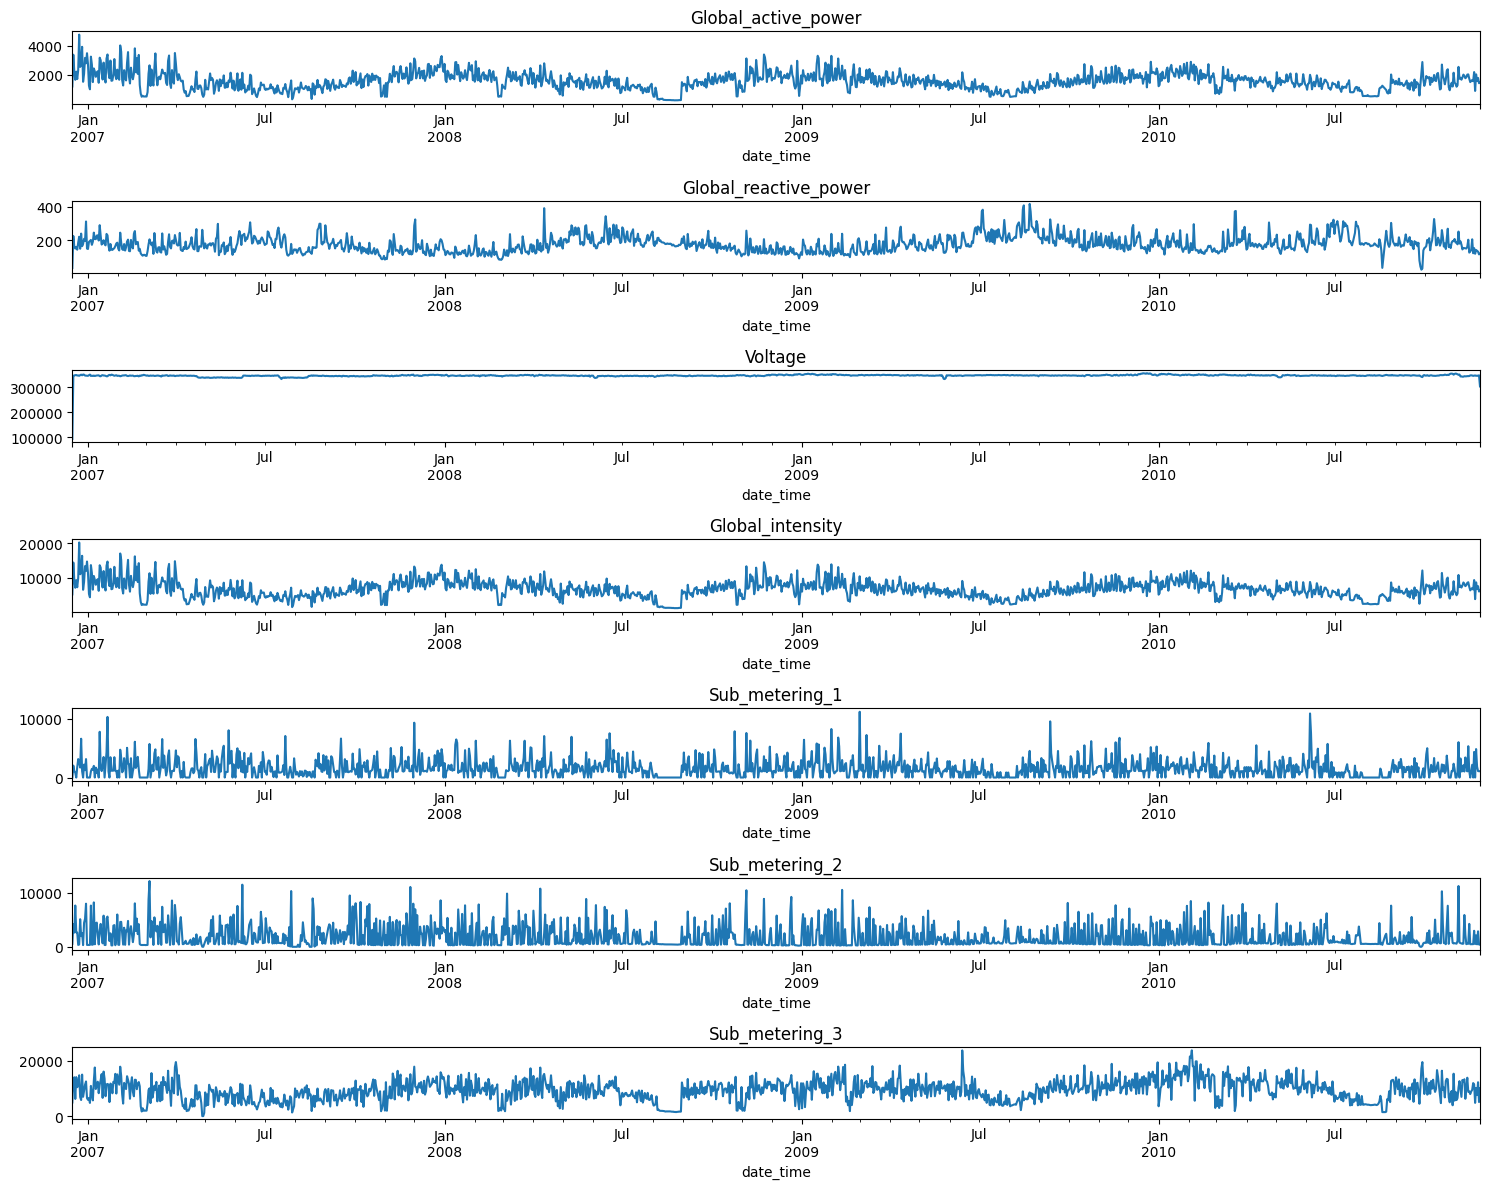

In [163]:
fig, axes = plt.subplots(len(data.columns), 1, figsize=(15, 12))
for i, name in enumerate(data.columns):
    data[name].plot(ax=axes[i], title=name, legend=False)
plt.tight_layout()
plt.show()

Visualizations - Yearly Plots

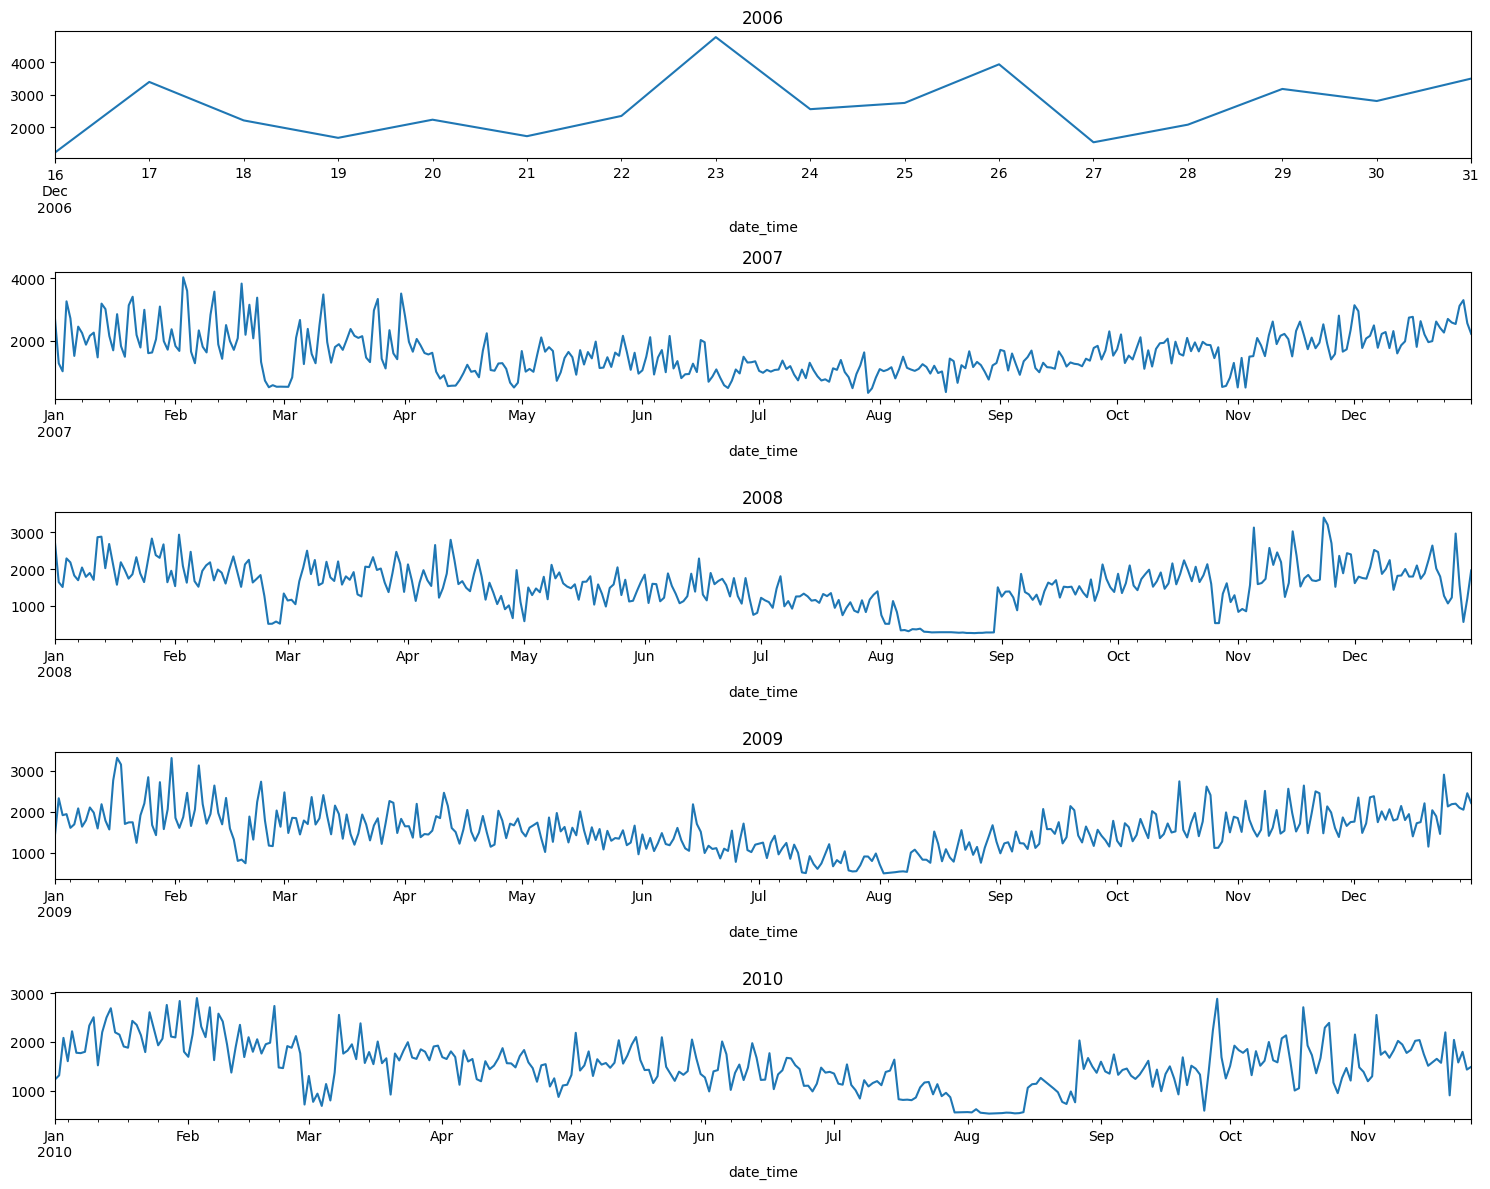

In [164]:
years = data.index.year.unique()
fig, axes = plt.subplots(len(years), 1, figsize=(15, 12))
for i, year in enumerate(years):
    data[data.index.year == year]['Global_active_power'].plot(ax=axes[i], title=year, legend=False)
plt.tight_layout()
plt.show()

Visualizations - Yearly Histograms

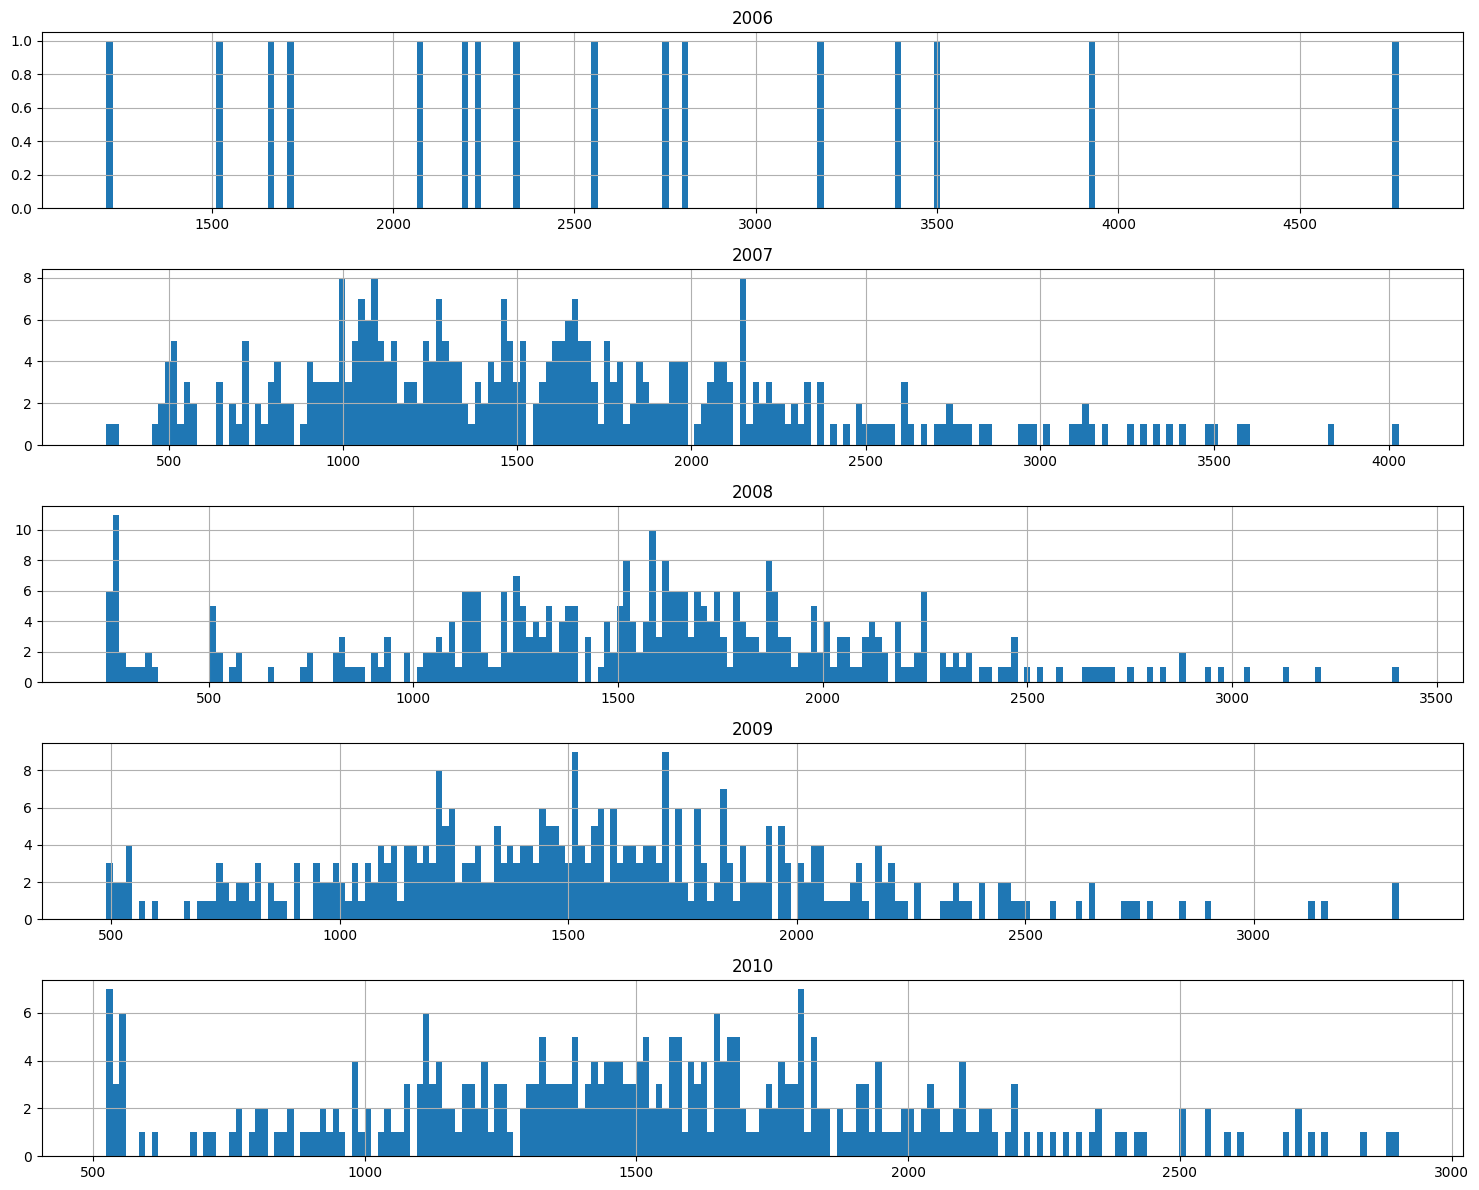

In [165]:
fig, axes = plt.subplots(len(years), 1, figsize=(15, 12))
for i, year in enumerate(years):
    data[data.index.year == year]['Global_active_power'].hist(bins=200, ax=axes[i])
    axes[i].set_title(year)
plt.tight_layout()
plt.show()

Visualizations - Column Histograms

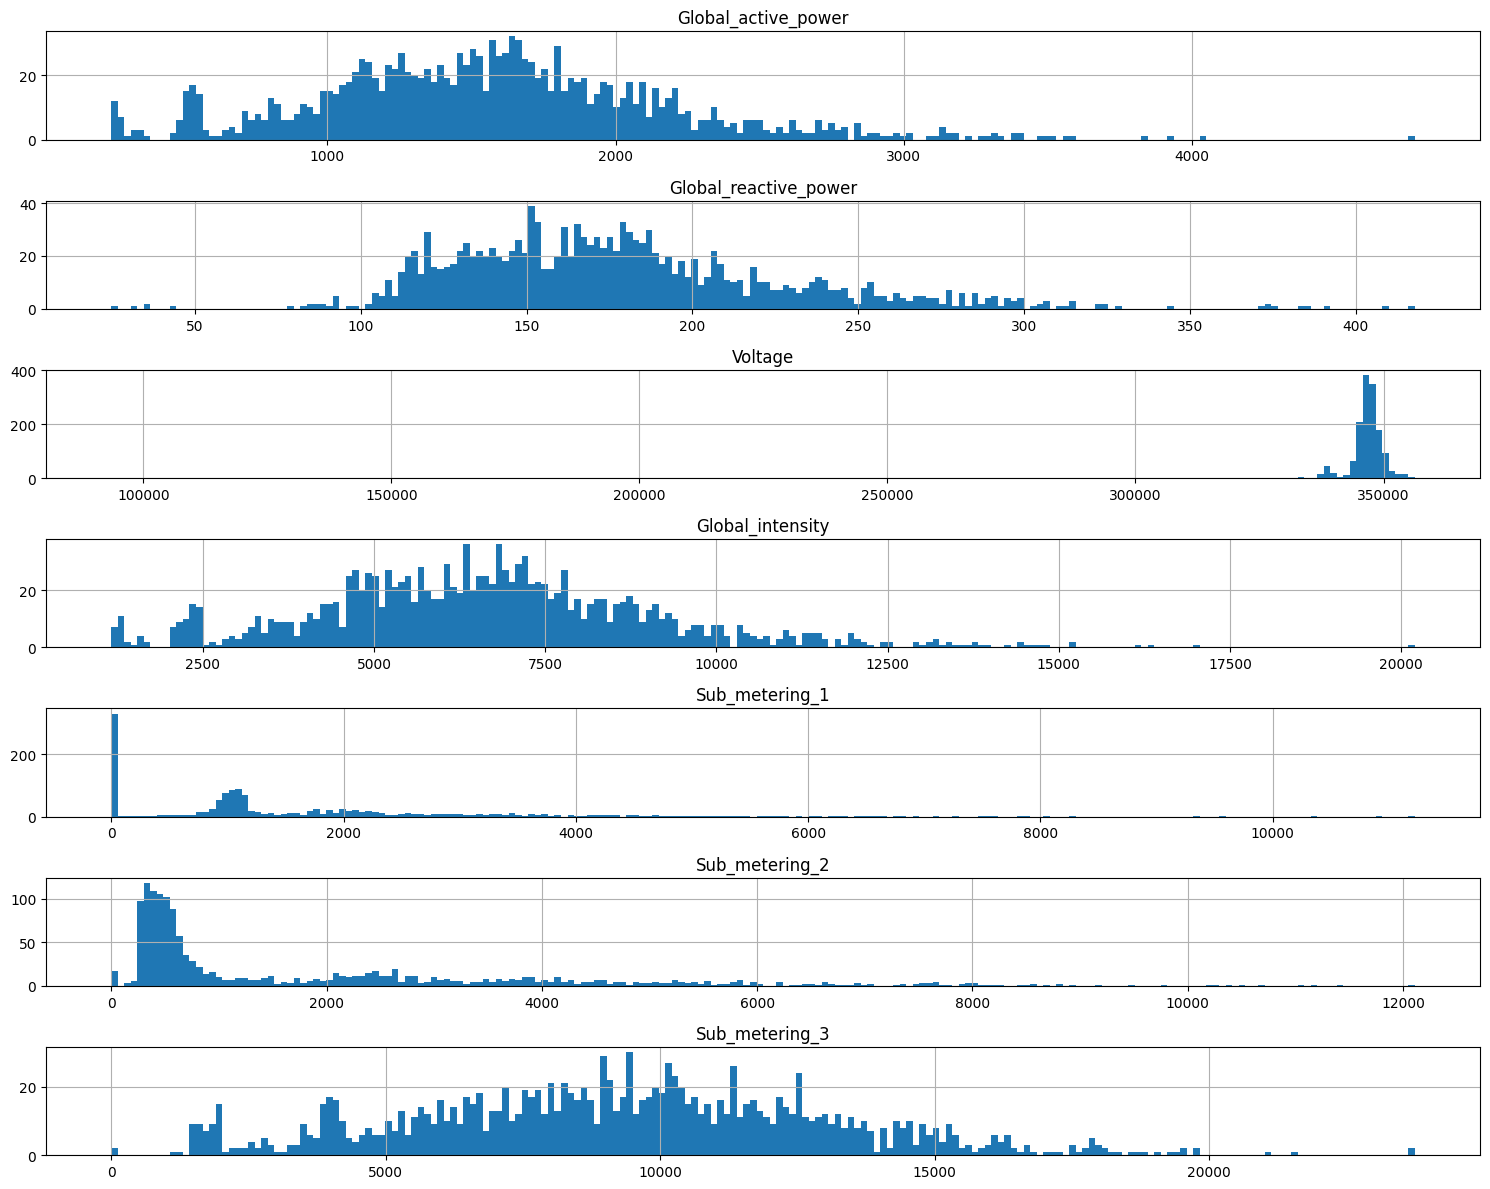

In [166]:
fig, axes = plt.subplots(len(data.columns), 1, figsize=(15, 12))
for i, name in enumerate(data.columns):
    data[name].hist(bins=200, ax=axes[i])
    axes[i].set_title(name)
plt.tight_layout()
plt.show()

Visualizations - Monthly Histograms

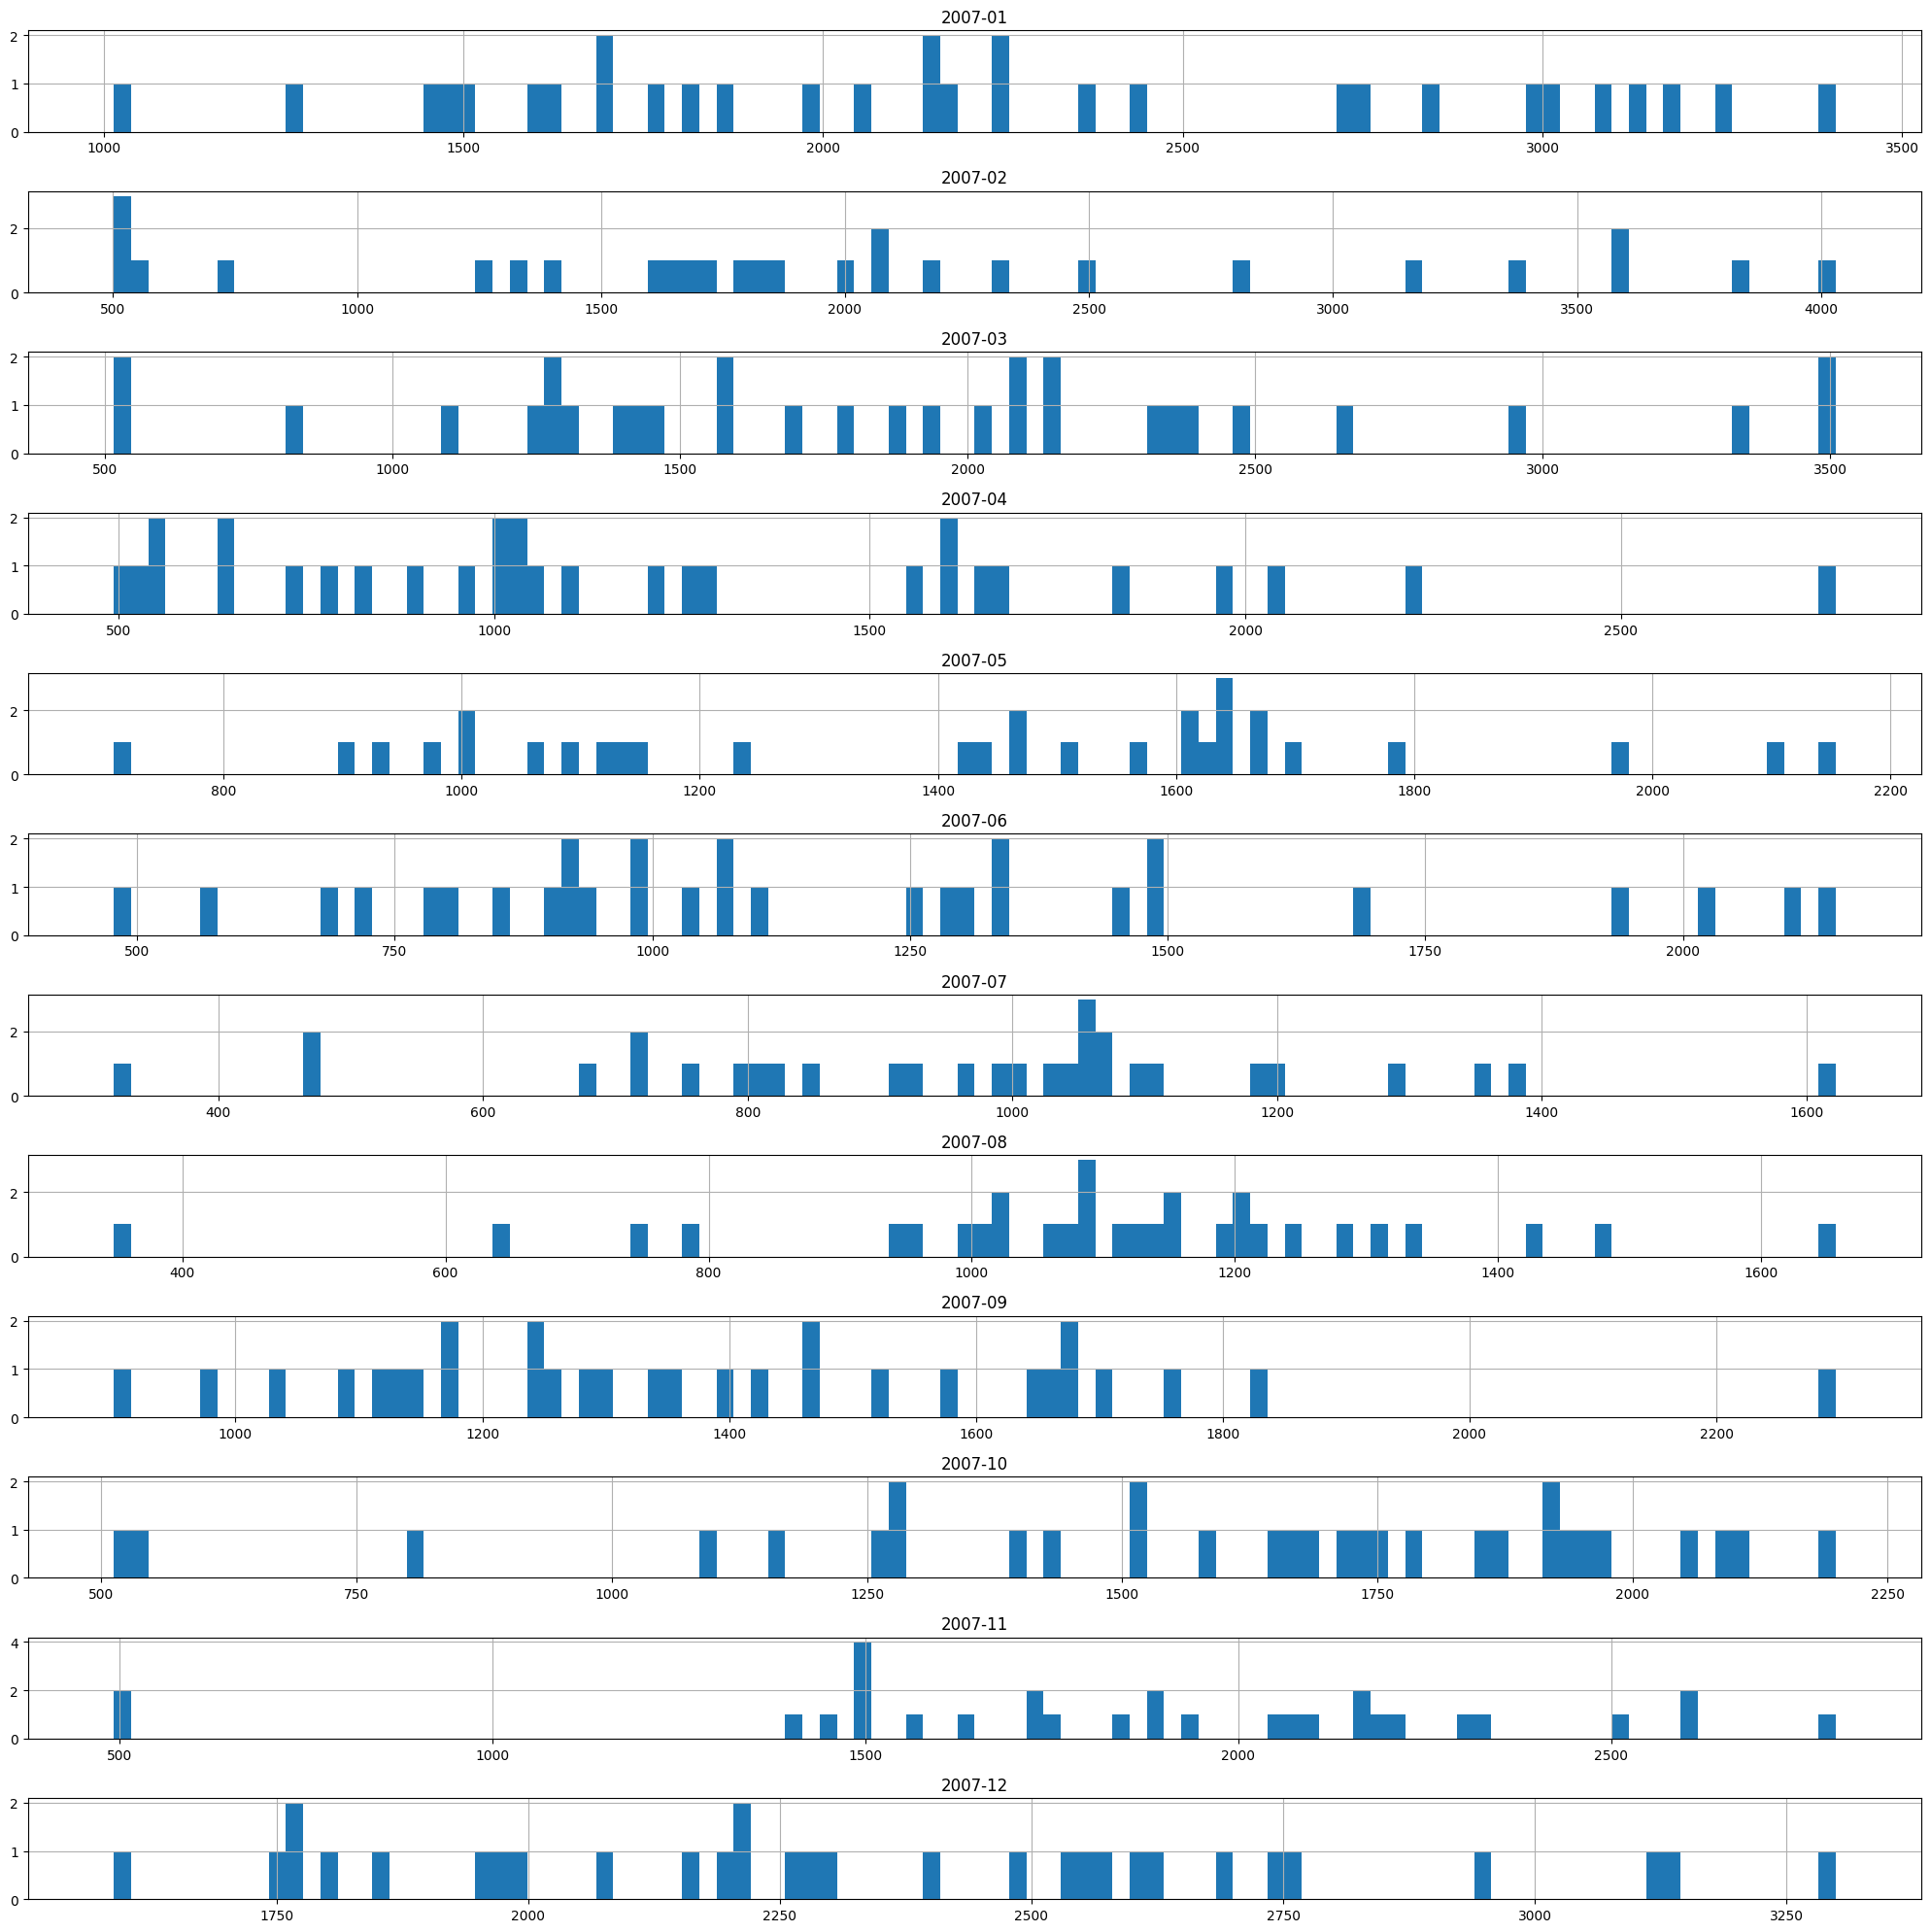

In [167]:
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
fig, axes = plt.subplots(len(months), 1, figsize=(20, 20))
for i, month in enumerate(months):
    month_str = '2007-' + month
    data[data.index.strftime('%Y-%m') == month_str]['Global_active_power'].hist(bins=100, ax=axes[i])
    axes[i].set_title(month_str)
plt.tight_layout()
plt.show()

### Prepare Training and Testing Data

In [168]:
data_train = data.loc[:'2009-12-31', 'Global_active_power'].values
data_test = data.loc['2010', 'Global_active_power'].values

Create Sequences for LSTM

In [169]:
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_steps = 7
X_train, y_train = prepare_data(data_train, n_steps)
X_test, y_test = prepare_data(data_test, n_steps)

Scale the Data

In [170]:
x_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))

 Reshape Data for LSTM

In [171]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Build the LSTM Model

In [172]:
reg = Sequential()
reg.add(LSTM(100, activation='relu', input_shape=(n_steps, 1)))
reg.add(Dropout(0.2))
reg.add(Dense(1))

Compile the Model

In [173]:
reg.compile(optimizer='adam', loss='mean_squared_error')

Train the Model

In [174]:
reg.fit(X_train, y_train, epochs=100, verbose=1)

Make Predictions

In [175]:
y_pred = reg.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 Inverse Transform Predictions

In [176]:
y_pred = y_scaler.inverse_transform(y_pred)
y_test = y_scaler.inverse_transform(y_test)

Evaluate the Model

In [177]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

rmse = evaluate_model(y_test, y_pred)
print(f'RMSE: {rmse}')

RMSE: 360.9527107184541


Visualize Predictions

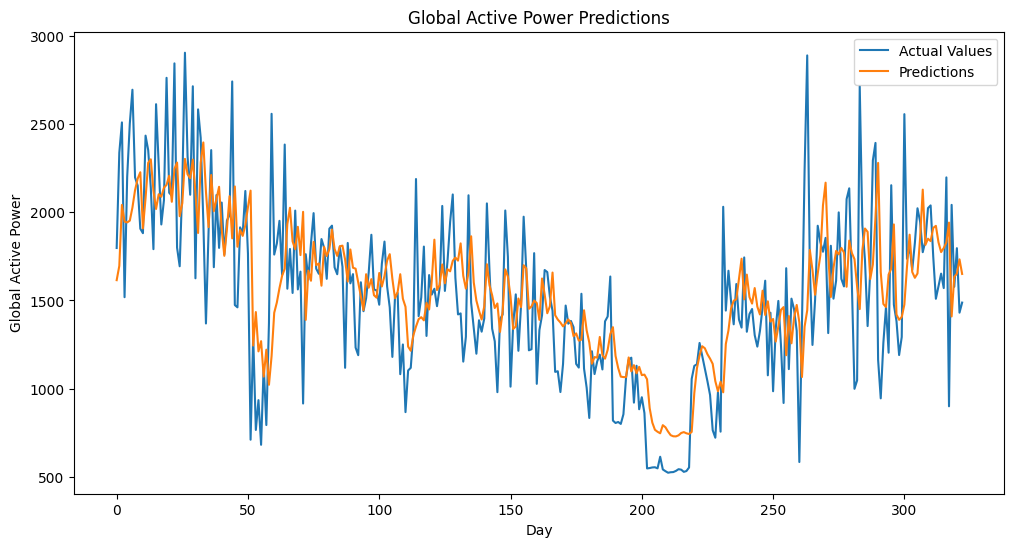

In [178]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(y_pred, label='Predictions')
plt.title('Global Active Power Predictions')
plt.xlabel('Day')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

Time Series Cross Validation

In [179]:
from sklearn.model_selection import TimeSeriesSplit

# TimeSeriesSplit nesnesi oluştur
tscv = TimeSeriesSplit(n_splits=5) # Örneğin 5 split

# Modeli, time series cross validation kullanarak değerlendir
i = 1
for train_index, test_index in tscv.split(X_train):
    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

    # Modeli yeniden oluştur (veya daha önce eğitilmiş modeli kullan)
    reg = Sequential()
    reg.add(LSTM(100, activation='relu', input_shape=(n_steps, 1)))
    reg.add(Dropout(0.2))
    reg.add(Dense(1))
    reg.compile(optimizer='adam', loss='mean_squared_error')

    reg.fit(X_train_cv, y_train_cv, epochs=20, verbose=0) # Epoch sayısını azalt
    y_pred_cv = reg.predict(X_test_cv)

    # Ölçeklendirmeyi geri al
    y_pred_cv = y_scaler.inverse_transform(y_pred_cv)
    y_test_cv = y_scaler.inverse_transform(y_test_cv)

    rmse = evaluate_model(y_test_cv, y_pred_cv)
    print(f'Fold {i}: RMSE = {rmse}')
    i += 1

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Fold 1: RMSE = 394.06600414778234


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Fold 2: RMSE = 427.52905603011357


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Fold 3: RMSE = 435.5989949196394
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Fold 4: RMSE = 428.3971944936148
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Fold 5: RMSE = 342.6267443406892


Residual Analysis

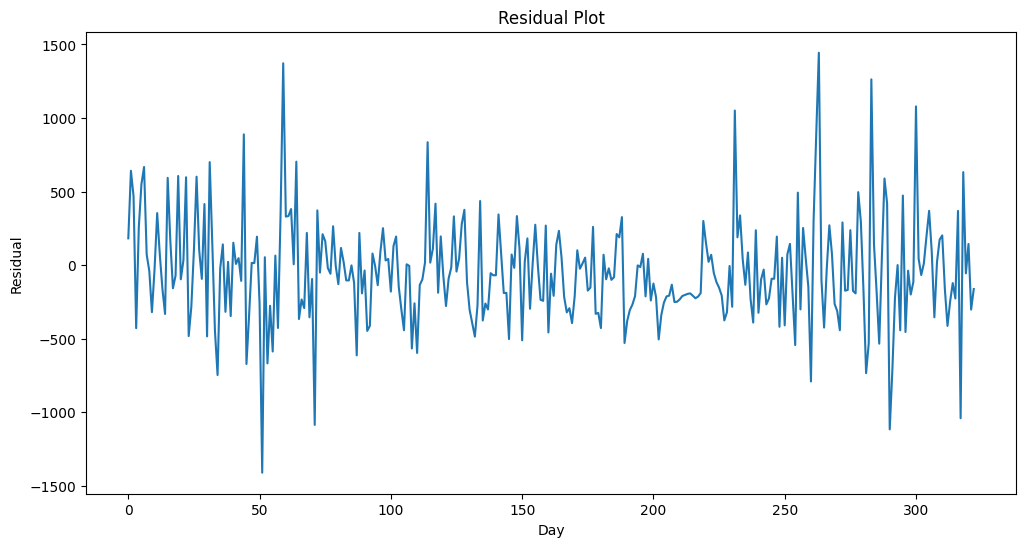

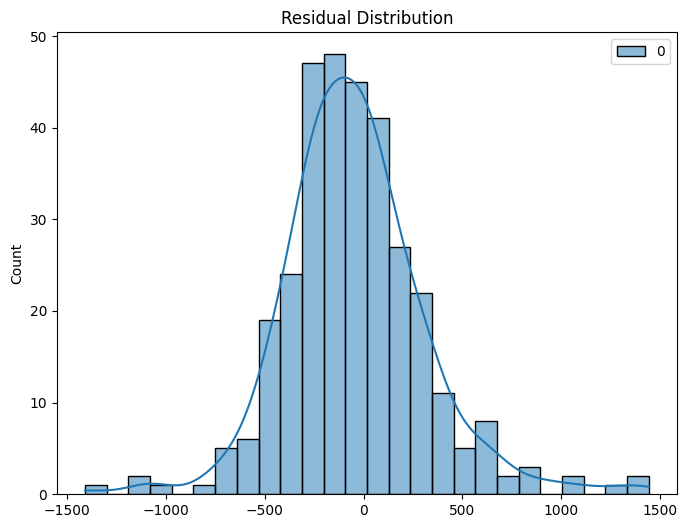

In [184]:
# Artıkları hesapla
residuals = y_test - y_pred

# Artıkların grafiğini çiz
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residual Plot')
plt.xlabel('Day')
plt.ylabel('Residual')
plt.show()

# Artıkların dağılımını çiz
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.show()